# Fake Job Post Predictions Project 
1. Data cleaning
2. EDA
3. Topic Modeling
4. Classification & Parameter tuning
    - Regularized logistic regression
    - XGBoost
    - Class imbalance: class weighting vs SMOTE
5. Select best model + predict on test set

In [2]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import scattertext as st
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import fastparquet

In [3]:
sw = stopwords.words("english")

## Load Data

In [4]:
df = pd.read_excel('./data/fake_job_postings.xlsx')

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


## Cleaning 
- Replace null to string "missing" -- instead of dropping missings, use as a valid observation. Could be that fake posts often have missing fields
- Separate country, state, city from location
- Drop non-english text entries
- Clean text columns: separate sentences, remove URLs, non-ascii, punctuation, extra spaces and white space
- Redefine education bins
- Drop salary range: very often missing, unsure what units are used in foreign countries, inconsistent time frame (hourly, monthly, yearly)

In [5]:
# replace null to "missing"
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [6]:
# separate location attributes
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [7]:
# drop non-english postings
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [8]:
# text cleaning 
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].apply(lambda x: re.sub(r'â€™', '', str(x))) # remove specific character used for apostrophe
                                                              # replace with '' before ascii removal so contractions together
    df[c] = df[c].str.replace('([A-Z])((?=[a-z]))', r' \1') # if lower case followed by upper case, separate by space
                                                            # works for a.A as well 
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) # empty strings mark as missing
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]','', x)) # remove punctuation. Replace with '' so don't separate contractions
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-8-1762eb734427>:12: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
<ipython-input-8-1762eb734427>:13: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs


In [9]:
# spot cleanup for nyc abbreviations
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

# spot cleanup experience
df.required_experience = np.where(df.required_experience == 'not applicable', 'missing', df.required_experience)

In [10]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [11]:
# drop salary range variable 
del df['salary_range']

## EDA

In [12]:
df.fraudulent = pd.to_numeric(df.fraudulent)

__Data Distributions__    
If lots of values, plot both head and tail to get sense of range

In [13]:
# Function to plot distribution of variables
# Inputs:
    # col: feature we want to graph distribution of
    # title: title of plot
    # boolean: True if variable is boolean -> different formatting
    # tail: True if plot head and tail of distribution if many values. False if plot all values
def hist_plt(col, title, boolean = False, tail = False):
    
    # 1 vs 2 plots in the figure
    if tail:
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        num = 10
    else:
        f, ax1 = plt.subplots()
        num = 1000
        
    # get value counts for distribution
    head = df[col].value_counts().head(num)
    
    # plot
    if boolean == False:
        ax1.bar(head.index, head)
        ax1.set_xticklabels(labels = head.index, rotation=90)
    # if boolean, need to sort in consistent No, Yes order rather than by value counts 
    else:
        bplt = df[col].value_counts()
        bplt = bplt.sort_index() # need to be in No, Yes order
        ax1.bar(bplt.index, bplt)
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(labels = ['No', 'Yes'])
    
    # second plot if need to plot distribution tail
    if tail:
        tail = df[col].value_counts().tail(10)
        ax2.bar(tail.index, tail)
        ax2.set_xticklabels(labels = tail.index, rotation=90)
        
    # title
    f.suptitle(title, fontsize=16)
    
    return ax1.get_figure()

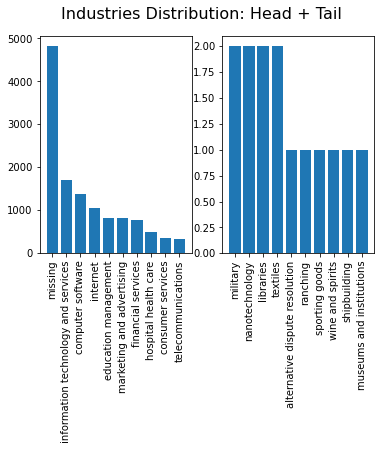

In [14]:
ind_dist = hist_plt('industry', 'Industries Distribution: Head + Tail', tail = True)

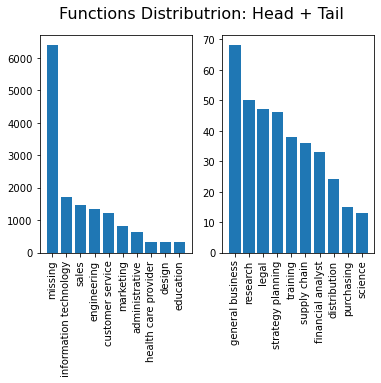

In [15]:
fun_dist = hist_plt('function', 'Functions Distributrion: Head + Tail', tail = True)

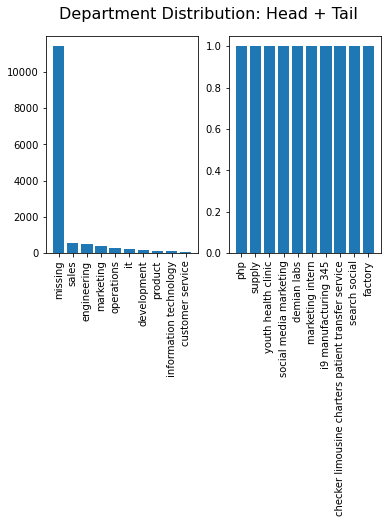

In [16]:
dep_dist = hist_plt('department', 'Department Distribution: Head + Tail', tail = True)

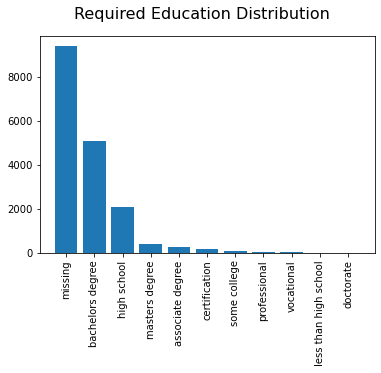

In [17]:
edu_dist = hist_plt('education_bin', 'Required Education Distribution')

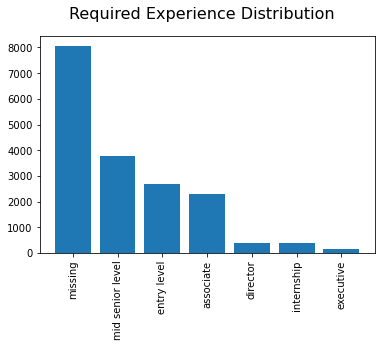

In [18]:
exp_dist = hist_plt('required_experience', 'Required Experience Distribution')

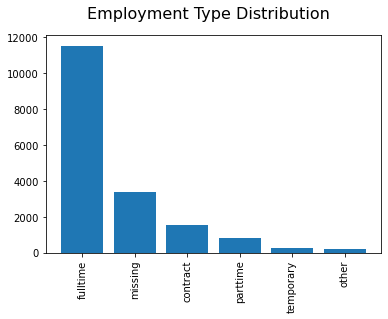

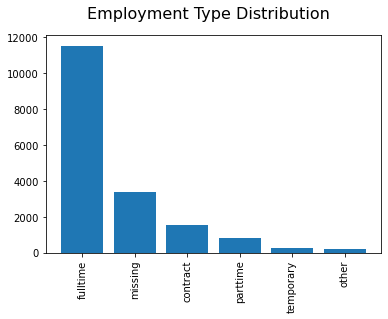

In [19]:
hist_plt('employment_type', 'Employment Type Distribution')

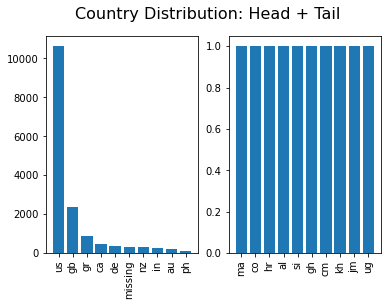

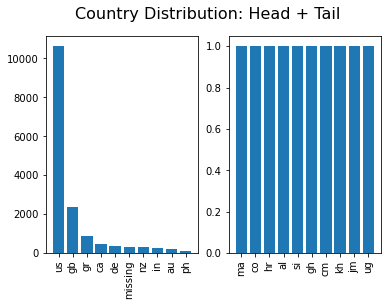

In [20]:
hist_plt('country', 'Country Distribution: Head + Tail', tail = True)

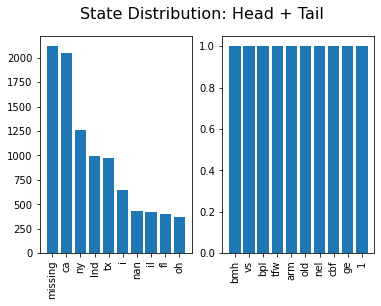

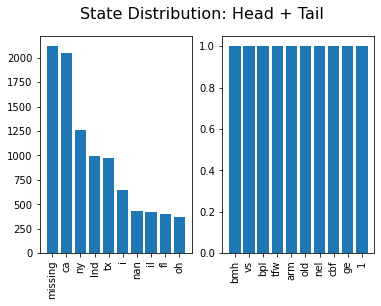

In [21]:
hist_plt('state', 'State Distribution: Head + Tail', tail = True)

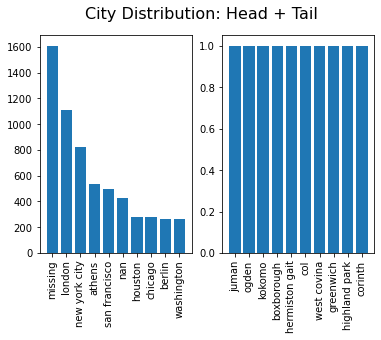

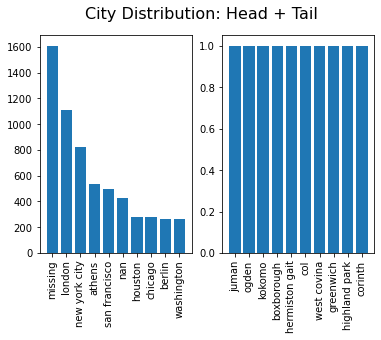

In [22]:
hist_plt('city', 'City Distribution: Head + Tail', tail = True)

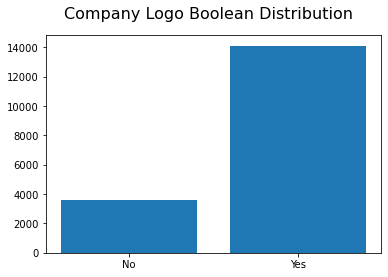

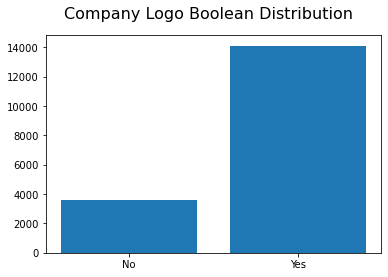

In [23]:
hist_plt('has_company_logo', 'Company Logo Boolean Distribution', boolean = True)

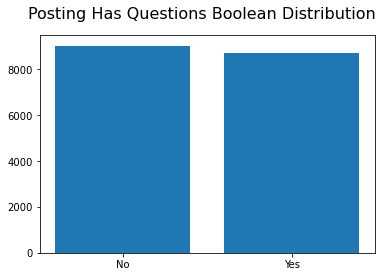

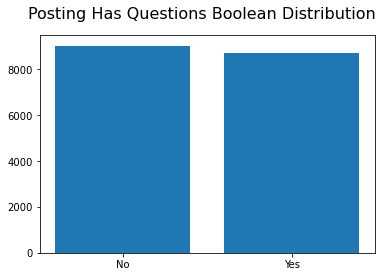

In [24]:
hist_plt('has_questions', 'Posting Has Questions Boolean Distribution', boolean = True)

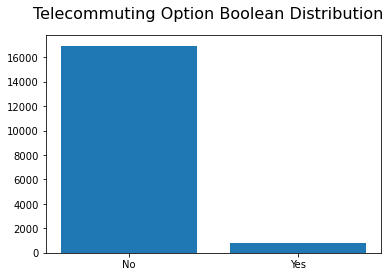

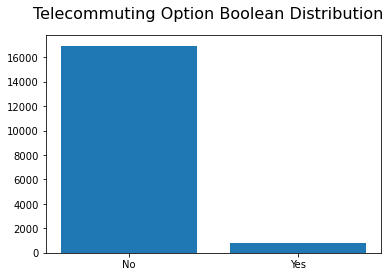

In [25]:
hist_plt('telecommuting', 'Telecommuting Option Boolean Distribution', boolean = True)

__Bar Plots of Metadata Frequency in Fraudulent Posts__

In [81]:
# function to plot percent of postings of each value that are fake
# inputs:
    # col: feature we want to plot
    # titlecol: title for graph
    # boolean: True if boolean value -> different formatting
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame() # number fraud
    totcnt = df.groupby(col).job_id.count().to_frame() # number in general
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True) # merge
    frac['frac'] = frac.fraudulent / frac.job_id # fraction fraud
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    # take top 10 if not boolean
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    
    # xtick format
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    # title
    # if top 10 was not the full amount, say top 10 in title. Else, all values
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    # label
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

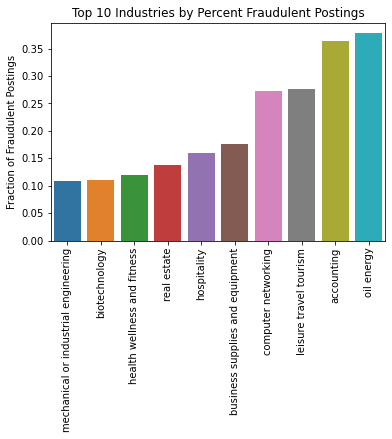

In [27]:
bar_plt('industry', 'Industries')

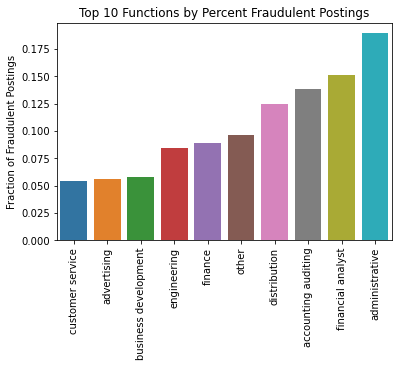

In [28]:
bar_plt('function', 'Functions')

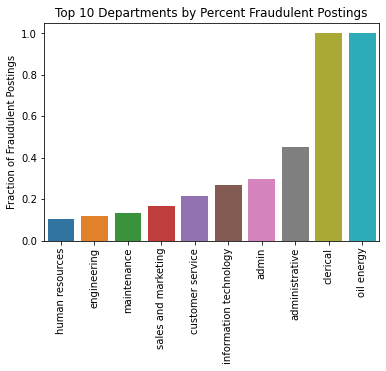

In [29]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

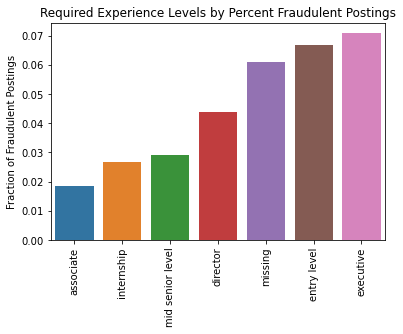

In [30]:
bar_plt('required_experience', 'Required Experience Levels')

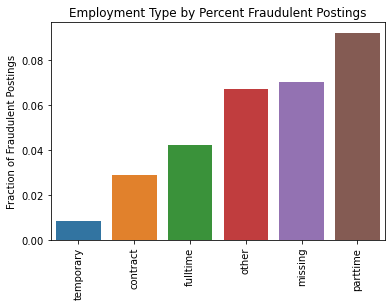

In [31]:
bar_plt('employment_type', 'Employment Type')

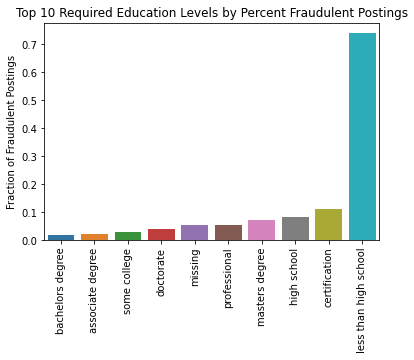

In [32]:
bar_plt('education_bin', 'Required Education Levels')

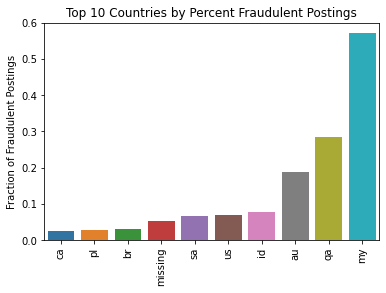

In [33]:
bar_plt('country', 'Countries')

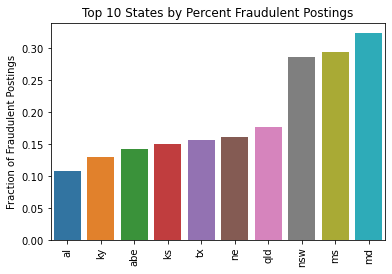

In [34]:
bar_plt('state', 'States')

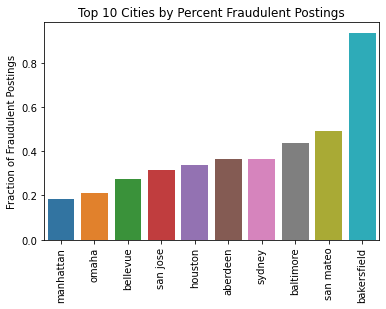

In [35]:
bar_plt('city', 'Cities')

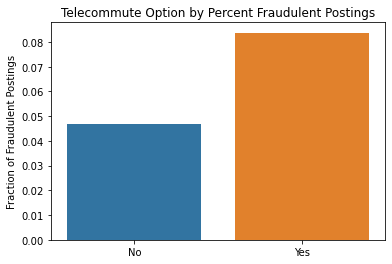

In [36]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

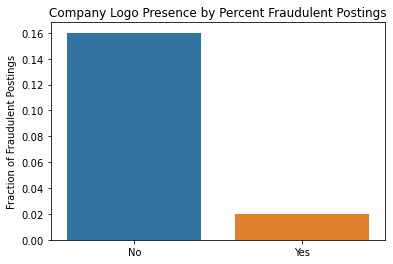

In [37]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

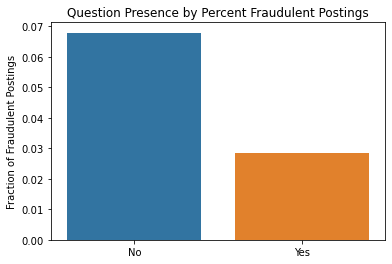

In [38]:
bar_plt('has_questions', 'Question Presence', boolean = True)

__Visualize Common Words in Fake vs Real Postings using Scattertext__   
Tokenize and remove stop words.    
Don't lemmatize for exploratory analysis, want words to be human readable

In [39]:
nlp = spacy.load('en')

In [40]:
# run in terminal (with admin priviledges): 'py -m spacy download en'
#nltk.download('stopwords')

In [41]:
# boolean to text (needed for scattertext)
df['fraudulent_words'] = np.where(df.fraudulent == 1, 'fake', 'real')

In [42]:
# combine text fields into single string 
for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
    df[c] = np.where(df[c] == 'missing', '', df[c])
    
df['text'] = (df.title + ' ' + df.company_profile + ' ' + df.description + ' ' + df.requirements + ' ' + df.benefits + ' ' +
              df.industry + ' ' + df.function)
# don't include location (country, state, city) here because will be excluded in lemmatization (proper noun)
# use as metadata

In [43]:
def scattertext_visualize(col):
    
    # spacy nlp cleaning
    df['parse'] = df[col].apply(st.whitespace_nlp_with_sentences)
    
    # corpus artifact
    # remove stop words
    corpus = st.CorpusFromParsedDocuments(
        df, category_col='fraudulent_words', parsed_col='parse'
    ).build().get_unigram_corpus().compact(st.AssociationCompactor(2000)).remove_terms(sw, ignore_absences=True)

    # create html figure
    html = st.produce_scattertext_explorer(
        corpus,
        category='fake', category_name='Fraudulent', not_category_name='Real',
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank,
        metadata=corpus.get_df()['title']
    )
    
    # save html
    open('./scattertext_' + col + '.html', 'w').write(html)

In [45]:
# visualize each text field separately and together (text)
nlp_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits', 'text']
for c in nlp_columns:
    scattertext_visualize(c)

## Topic Modeling
Sections of code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling

- Combine text fields into single string
- Tokenize, remove stop words, lemmatize based on POS 
- Build term frequency corpus
- Build LDA Model
    - Tune based on topic coherence. Specificall C_V coherence
- Add topic probabilities as metadata to dataset
    
Topic coherence: Degree of semantic similarity between high scoring words in the topic    
Modern alternative to perplexity: how suprised a model is by new data (normalized log likelihood of held out test set)    
CV_coherence: "C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity"       
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0   
  
Parameters:
- Number of Topics
- Alpha
- Eta
    - Selecting alpha and eta with built in auto method which learns an asymetric prior from the data
     
From https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/: (assuming symmetric data)
"alpha represents document-topic density - with a higher alpha, documents are made up of more topics, and with lower alpha, documents contain fewer topics. Beta represents topic-word density - with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words"

In [46]:
# function from
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [47]:
# tokenize
df.text = df.text.apply(lambda row: row.split(' '))
# remove stop words
df.text = df.text.apply(lambda row: [w for w in row if w not in sw])

# convert into list 
text = df.text.values.tolist()

# lemmatize and remove proper nouns 
# ex removing company names. Not important for topic modeling. 
text = lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [48]:
# save text string (10 minutes to run tokenization through lemmatization process)
with open('textlst.pkl', 'wb') as f:
    pickle.dump(text, f)

In [49]:
with open('textlst.pkl', 'rb') as f:
    text = pickle.load(f)

In [50]:
# term document frequency corpus for LDA
corpus_dict = corpora.Dictionary(text)
corpus = [corpus_dict.doc2bow(t) for t in text]

In [62]:
# tune LDA model based on topic coherence values (maximize)
# build LDA with many values for topic and find topic number with maximum topic coherence score
# inputs:
    # dictionary: corpus dictionary 
    # corpus: BOW corpus
    # texts: text strings as a list 
    # limit: maximum number of topics to iterate through
    # start: minimum number of topics to iterate through
    # step: step size as iterate
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):

    coherence_values = []
    model_list = []
    # loop through possible number of topics
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        # build LDA model 
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=corpus_dict,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta = 'auto',
                                                per_word_topics=True)
        # record models
        model_list.append(model)
        # calculate coherence value and store for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [74]:
model_list, coherence_values = compute_coherence_values(dictionary=corpus_dict, corpus=corpus, texts=text, 
                                                        start=2, limit=25, step=1)
# 2.5 hours to run

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [75]:
# max number of topics
np.argmax(coherence_values) # started at 2, so 22 topics

20

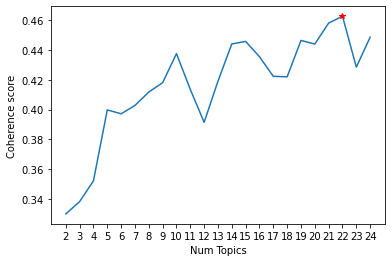

In [76]:
# graph topic coherence vs number of topics
limit=25; start=2; step=1; 
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(range(2, 25))
plt.plot(np.argmax(coherence_values) + 2, coherence_values[np.argmax(coherence_values)], 'r*')

In [78]:
with open('model_list.pkl', 'wb') as f:
    pickle.dump(model_list, f)
    
with open('coherence_values.pkl', 'wb') as f:
    pickle.dump(coherence_values, f)

In [66]:
#with open('model_list.pkl', 'rb') as f:
#    model_list = pickle.load(f)
    
#with open('coherence_values.pkl', 'rb') as f:
#    coherence_values = pickle.load(f)

In [79]:
# get best lda model from list
lda_model_best = model_list[np.argmax(coherence_values)]

In [80]:
# visualize topics using LDAvis and save html
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_best, corpus, corpus_dict)
pyLDAvis.save_html(vis, 'topic_vis.html')

In [82]:
# reconstruct dataframe with metadata columns with topic probabilities 

# blank dataframe
topicdf = pd.DataFrame()
for i in range(0, np.argmax(coherence_values)+2):
    topicdf['topic' + str(i)] = 0
    
# loop through LDA results, create series with topic probabilities, and append onto main df 
for i, row in enumerate(lda_model_best[corpus]):
    s = pd.Series(dtype = float)
    
    for j in row[0]:
        s['topic' + str(j[0])] = j[1] 
    topicdf = topicdf.append(s, ignore_index = True)

In [83]:
# merge with original data (other columns)
df = df.reset_index(drop = True)
df = pd.merge(df, topicdf, how = 'left', left_index = True, right_index = True)

# replace missings with 0s: if topic is missing, then 0% probability in that topic
topic_cols = [c for c in df.columns if c.startswith('topic')]
for c in topic_cols:
    df[c] = np.where(df[c].isnull(), 0, df[c])

In [84]:
# save final dataframe ready for classification 
with open('finaldf.pkl', 'wb') as f:
    pickle.dump(df, f)

In [6]:
with open('finaldf.pkl', 'rb') as f:
    df = pickle.load(f)

# Classification

### Dummy Variables
All variables are categorical, create dummies and drop one level to avoid collinearity    
For country, many values so only create dummy if more than 100 posts in that country

In [7]:
# convert telecommuting, has_questions, has_company_logo to numeric
for c in ['telecommuting', 'has_questions', 'has_company_logo']:
    df[c] = pd.to_numeric(df[c])

In [8]:
for c in ['employment_type', 'required_experience', 'education_bin', 'country']:
    
    # many values for country, only create dummy if more than 100 job postings in that country
    if c == 'country':
        cnts = df.country.value_counts()
        cnts = cnts[cnts > 100]   
        df.country = np.where(df.country.isin(cnts.index), df.country, 'other')
    
    # create dummies 
    prefix = c
    dum = pd.get_dummies(df[c], prefix = c)
    df = df.join(dum)
    
# remove columns not needed for modeling
df_mod = df.drop(columns = ['employment_type', 'required_experience','required_education', 'education_bin', 'country',
                            'location', 'title', 'department', 'company_profile', 'description', 'requirements', 'benefits', 
                            'industry', 'function', 'state', 'city', 'language', 'fraudulent_words', 'job_id', 'text', 'parse'])

# remove one level from dummies to prevent collinearity for regression
# different dataset from the above line of code because only need to do this for regression, not trees
df_reg = df_mod.drop(columns = ['employment_type_missing', 'required_experience_missing', 'education_bin_missing',
                                'country_missing'])

### SMOTE: class imbalance
SMOTE sampling on the training data such that even number of observations with each class    
This funciton also does 80/20 train/test split    
    
SMOTE: synethic minority over-sampling technique    
Synthesize new examples for the minority class rateher than oversample, which doesn't add any new information. 
                     
"… SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b"

In [9]:
# code adapted from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

def smote(df_reg):

    # X and Y data frames
    X = df_reg.loc[:, df_reg.columns != 'fraudulent']
    y = df_reg.loc[:, df_reg.columns == 'fraudulent']

    # oversample setup
    os = SMOTE(random_state=0)

    # test-train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # oversample training data 
    columns = X_train.columns
    os_data_X,os_data_y=os.fit_sample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['fraudulent'])

    # check the numbers of our data
    print("Original number of fraudulent in data is", len(y_train[y_train.fraudulent == 1]))
    print("length of oversampled data is ",len(os_data_X))
    print("Number of real in oversampled data",len(os_data_y[os_data_y['fraudulent']==0]))
    print("Number of fraudulent",len(os_data_y[os_data_y['fraudulent']==1]))
    print("Proportion of real data in oversampled data is ",len(os_data_y[os_data_y['fraudulent']==0])/len(os_data_X))
    print("Proportion of fraudulent data in oversampled data is ",len(os_data_y[os_data_y['fraudulent']==1])/len(os_data_X))
    
    # return imbalanced train, test and SMOTE train
    return X_train, X_test, y_train, y_test, os_data_X, os_data_y

### Set up Evaluation Functions

In [10]:
# predict on test data 
# inputs: 
    # model: trained model on train data
    # logistic: True if logistic model and thus can return coefficients. No coefficients for tree models
    
def model_predict(model, logistic = True):
    # predict on test data
    predict = model.predict(X_test.values)

    # dataframe from true values
    true_df = pd.DataFrame(y_test.fraudulent.to_list())

    # predict probabilities rather than class (useful for some metric calculations)
    prob = model.predict_proba(X_test.values) 
    prob_df = pd.DataFrame(prob)
    
    if logistic:
        # get coefficients
        coef_dict = {}
        for coef, feat in zip(model.coef_[0,:], X_train.columns):
            coef_dict[feat] = coef

    # create dataframe from real and fake 
    predict_df = pd.DataFrame(predict)
    predict_df = pd.merge(true_df, predict_df, left_index = True, right_index = True)
    predict_df.columns = ['truth', 'predict']

    if logistic:
        return predict, prob, predict_df, true_df, prob_df, coef_dict
    else:
        return predict, prob, predict_df, true_df, prob_df

In [11]:
# print variety of metrics used to assess model performance and return list of metrics for graphic
# inputs predict_df and predict from the above model_predict function 

def metrics_print(predict_df, predict):
    # accuracy 
    accuracy = len(predict_df[predict_df.truth == predict_df.predict]) / len(predict_df)
    print('Accuracy:', accuracy)

    # true positive rate: predict fraudulent when actually fraudulent (recall)
    tpr = len(predict_df[(predict_df.truth == predict_df.predict) & (predict_df.truth == 1)]
             ) / len(predict_df[predict_df.truth == 1])
    print('TPR/recall:', tpr)

    # true negative rate: predict real when actually real
    tnr = len(predict_df[(predict_df.truth == predict_df.predict) & (predict_df.truth == 0)]
             ) / len(predict_df[predict_df.truth == 0])
    print('TNR:', tnr)

    # false positive rate: predict fraudulent when actually real (companies upset)
    fpr = len(predict_df[(predict_df.predict == 1) & (predict_df.truth == 0)]) / len(predict_df[predict_df.truth == 0])
    print('FPR:', fpr)

    # false negative rate: predict real when actually fake (job seekers upset) (1-recall)
    fnr = len(predict_df[(predict_df.predict == 0) & (predict_df.truth == 1)]) / len(predict_df[predict_df.truth == 1])
    print('FNR:', fnr)
    
    # precision: positive predictive value aka when predict fake, get it right (actually fake)
    try:
        precision = len(predict_df[(predict_df.truth == predict_df.predict) & (predict_df.truth == 1)]
                   ) / len(predict_df[predict_df.predict == 1])
        print('Precision:', precision)
    except ZeroDivisionError:
        precision = 0
        print('Precision: No fake predictions')
        
    # curve areas
    roc = roc_auc_score(y_test.fraudulent.to_list(), predict)
    pr = average_precision_score(y_test.fraudulent.to_list(), predict)
    print('Area under ROC:', roc)
    print("Area Under PR:", pr)
    
    return [accuracy, tpr, tnr, fpr, fnr, precision, roc, pr]

### Unregularized Logistic Regression: Baselines
3 versions: original imbalanced data, balanced weighting, SMOTE

In [12]:
X_train, X_test, y_train, y_test, os_data_X, os_data_y = smote(df_reg)

Original number of fraudulent in data is 687
length of oversampled data is  26956
Number of real in oversampled data 13478
Number of fraudulent 13478
Proportion of real data in oversampled data is  0.5
Proportion of fraudulent data in oversampled data is  0.5


In [92]:
# imbalanced data 
lr_imb = LogisticRegression(random_state = 1, solver = 'saga', fit_intercept = False
                             ).fit(X_train, y_train.fraudulent.to_list())

In [98]:
predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(lr_imb) 
imb_metric = metrics_print(predict_df, predict)
# very bad recall and ROC (effectively random guessing). Good accuracy. Rarely predict the fake class. 

Accuracy: 0.9551101072840203
TPR/recall: 0.19653179190751446
TNR: 0.9940635203324428
FPR: 0.005936479667557139
FNR: 0.8034682080924855
Precision: 0.6296296296296297
Area under ROC: 0.5952976561199786
Area Under PR: 0.16298560467949763


In [94]:
# balanced class weighting
lr = LogisticRegression(class_weight = 'balanced',  random_state = 1, solver = 'saga', fit_intercept = False
                             ).fit(X_train, y_train.fraudulent.to_list())

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [99]:
predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(lr)
bal_metric = metrics_print(predict_df, predict)

Accuracy: 0.8215697346132129
TPR/recall: 0.8092485549132948
TNR: 0.8222024339566637
FPR: 0.1777975660433363
FNR: 0.1907514450867052
Precision: 0.18944519621109607
Area under ROC: 0.8157254944349792
Area Under PR: 0.16262502145543048


In [13]:
# SMOTE 
lr_smote = LogisticRegression(random_state = 1, solver = 'saga', fit_intercept = False
                             ).fit(os_data_X, os_data_y.fraudulent.to_list())

In [14]:
predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(lr_smote)
smote_metric = metrics_print(predict_df, predict)

Accuracy: 0.8204404291360813
TPR/recall: 0.7976878612716763
TNR: 0.8216087859899079
FPR: 0.178391214010092
FNR: 0.2023121387283237
Precision: 0.18673883626522328
Area under ROC: 0.8096483236307922
Area Under PR: 0.1588407258416689


Baseline model comparison:    
Imbalanced model is heavily biased towards accuracy and precision, not recall. SMOTE and class weighting are very similar.

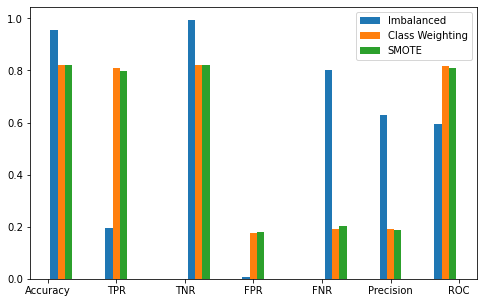

In [195]:
# compare baseline models 
# Imbalanced heavily biased towards accuracy and precision, not recall 
# SMOTE and class weighting very similar 
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins], 15, weights=[imb_metric[:-1], bal_metric[:-1], smote_metric[:-1]], 
            histtype='bar', label=['Imbalanced', 'Class Weighting', 'SMOTE'])
plt.legend()

## Regularized (Lasso) Logistic Regression w/ CV
- Cross Validation to choose regularization parameter
- No need to scale or normalize since all features are categorical or probabilities between 0 and 1    
- refit =  true means will refit with the best selected parameters after CV       
- Fit without intercept so can include all topic levels (which sum to 1). Still need to remove 1 level from the other dummies. 
- Increasing max_iter even to 5000 does not get rid of convergence warning

Iterations: repeat the following each with these 4 scoring metrics: roc auc, accuracy, precision, recall
1. Balanced weighting
    - class_weigthing = 'balanced'
    - penalty = 'l1' 
    - fit(X_train, y_train)
2. SMOTE 
    - penalty = 'l1'
    - fit(os_data_X, os_data_y)
3. SMOTE with elastic net penalty
    - SMOTE better than balanced weighting so keep with that
    - penalty = 'elasticnet'
    - l1_ratios = [0, .25, .5, .75, 1]
    - fit(os_data_X, os_data_y)

In [15]:
# fit logistic regressions for 4 different scoring metrics and save list of models
# inputs:
    # x,y: input training data
    # penalty: type of logistic penalty (l1, l2, elasticnet)
    # l1_ratios: if tuning elasticnet penalty, give l1 ratios to search through
    # weighting: if class imbalance weighting, give 'balanced', else None
    # filename: filename to save model list to 
def logistic_iteration(x, y, penalty, l1_ratios, weighting, filename):

    lrcv_roc = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'roc_auc', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_acc = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'accuracy', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_prec = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'precision', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    lrcv_rec = LogisticRegressionCV(cv = 5, penalty = penalty, scoring = 'recall', l1_ratios = l1_ratios, class_weight = weighting,
                                random_state = 1, solver = 'saga', refit = True, fit_intercept = False, max_iter = 1000,
                                 ).fit(x, y.fraudulent.to_list())
    
    model_list = [lrcv_roc, lrcv_acc, lrcv_prec, lrcv_rec]
    
    # save model list
    with open(filename + '.pkl', 'wb') as f:
        pickle.dump(model_list, f)

In [103]:
# balanced weighting
logistic_iteration(X_train, y_train, 'l1', None, 'balanced', 'lasso_list_scoring')

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

In [104]:
# SMOTE 
logistic_iteration(os_data_X, os_data_y, 'elasticnet', [0, 0.25, 0.5, 0.75, 1], None, 'lasso_list_scoring_smote')

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not conv

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not conv

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

In [105]:
# elastic net with smote
logistic_iteration(os_data_X, os_data_y, 'l1', None, None, 'lasso_list_scoring_smote_elasticnet') 

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\gimli\a

In [20]:
with open('lasso_list_scoring.pkl', 'rb') as f:
    model_list = pickle.load(f)
with open('lasso_list_scoring_smote.pkl', 'rb') as f:
    model_list_smote = pickle.load(f)
with open('lasso_list_scoring_smote_elasticnet.pkl', 'rb') as f:
    model_list_en = pickle.load(f)

__Iterate through model lists and print/graph metrics__

In [107]:
# class weighting
# best model: precision or recall
stats = []
for i in model_list:
    print(str(i))
    predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(i)
    stats.append(metrics_print(predict_df, predict))

LogisticRegressionCV(class_weight='balanced', cv=5, fit_intercept=False,
                     max_iter=1000, penalty='l1', random_state=1,
                     scoring='roc_auc', solver='saga')
Accuracy: 0.7569169960474308
TPR/recall: 0.8670520231213873
TNR: 0.7512615019293559
FPR: 0.2487384980706441
FNR: 0.1329479768786127
Precision: 0.15182186234817813
Area under ROC: 0.8091567625253716
Area Under PR: 0.13813095939655112
LogisticRegressionCV(class_weight='balanced', cv=5, fit_intercept=False,
                     max_iter=1000, penalty='l1', random_state=1,
                     scoring='accuracy', solver='saga')
Accuracy: 0.9511575381140599
TPR/recall: 0.0
TNR: 1.0
FPR: 0.0
FNR: 1.0
Precision: No fake predictions
Area under ROC: 0.5
Area Under PR: 0.048842461885940144
LogisticRegressionCV(class_weight='balanced', cv=5, fit_intercept=False,
                     max_iter=1000, penalty='l1', random_state=1,
                     scoring='precision', solver='saga')
Accuracy: 0.84782608695

Insights:

1. Accuracy FPR = 0, FNR = 1. Almost always predicts real.
2. ROC, precision, recall all pretty similar.
3. Recall does the best at minimizing FNR (as is its purpose) and everything else is just slightly worse
4. Precision more balanced, unclear which is better
5. Baseline only slightly worse than tuned results
    
Best: Recall or precision

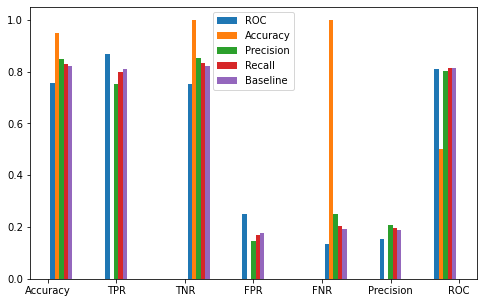

In [198]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins, bins], 15, 
         weights=[stats[0][:-1], stats[1][:-1], stats[2][:-1], stats[3][:-1], bal_metric[:-1]], 
         histtype='bar', label=['ROC', 'Accuracy', 'Precision', 'Recall', 'Baseline'])
plt.legend()

In [109]:
# SMOTE
# best model: ROC (all effectively the same incl baseline)
stats_smote = []
for i in model_list_smote:
    print(str(i))
    predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(i)
    stats_smote.append(metrics_print(predict_df, predict))

LogisticRegressionCV(cv=5, fit_intercept=False,
                     l1_ratios=[0, 0.25, 0.5, 0.75, 1], max_iter=1000,
                     penalty='elasticnet', random_state=1, scoring='roc_auc',
                     solver='saga')
Accuracy: 0.82128740824393
TPR/recall: 0.7976878612716763
TNR: 0.8224992579400415
FPR: 0.17750074205995844
FNR: 0.2023121387283237
Precision: 0.1875
Area under ROC: 0.8100935596058589
Area Under PR: 0.1594478969133405
LogisticRegressionCV(cv=5, fit_intercept=False,
                     l1_ratios=[0, 0.25, 0.5, 0.75, 1], max_iter=1000,
                     penalty='elasticnet', random_state=1, scoring='accuracy',
                     solver='saga')
Accuracy: 0.82128740824393
TPR/recall: 0.7976878612716763
TNR: 0.8224992579400415
FPR: 0.17750074205995844
FNR: 0.2023121387283237
Precision: 0.1875
Area under ROC: 0.8100935596058589
Area Under PR: 0.1594478969133405
LogisticRegressionCV(cv=5, fit_intercept=False,
                     l1_ratios=[0, 0.25, 0.5, 0.7

Insights: Effectively all the same including baseline. Very robust, low variation.     
Best model: ROC

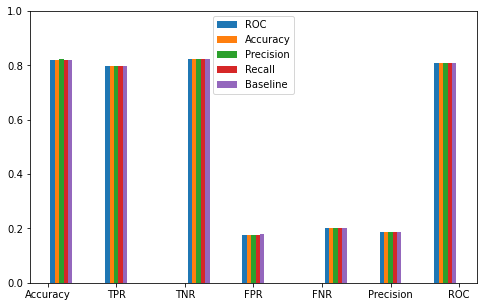

In [203]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins, bins], 15,
         weights=[stats_smote[0][:-1], stats_smote[1][:-1], stats_smote[2][:-1], stats_smote[3][:-1], smote_metric[:-1]], 
         histtype='bar', label=['ROC', 'Accuracy', 'Precision', 'Recall', 'Baseline'])
plt.ylim([0,1])
plt.legend()

In [21]:
# Elastic Net
stats_en = []
for i in model_list_en:
    print(str(i))
    predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(i)
    stats_en.append(metrics_print(predict_df, predict))

LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='roc_auc', solver='saga')
Accuracy: 0.82128740824393
TPR/recall: 0.7976878612716763
TNR: 0.8224992579400415
FPR: 0.17750074205995844
FNR: 0.2023121387283237
Precision: 0.1875
Area under ROC: 0.8100935596058589
Area Under PR: 0.1594478969133405
LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='accuracy', solver='saga')
Accuracy: 0.8218520609824957
TPR/recall: 0.7976878612716763
TNR: 0.8230929059067973
FPR: 0.17690709409320274
FNR: 0.2023121387283237
Precision: 0.1880108991825613
Area under ROC: 0.8103903835892369
Area Under PR: 0.15985543498960328
LogisticRegressionCV(cv=5, fit_intercept=False, max_iter=1000, penalty='l1',
                     random_state=1, scoring='precision', solver='saga')
Accuracy: 0.8218520609824957
TPR/recall: 0.7976878612716763
TNR: 0.8230929059067973
FPR: 0.17690709409

# UPDATED
Insights: Not materially different from lasso smote, not using

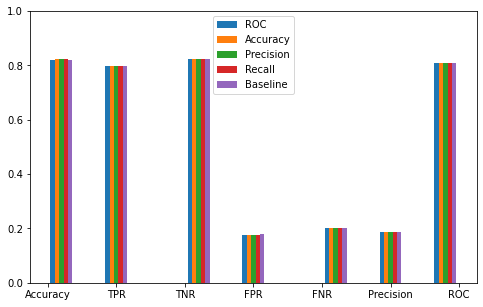

In [23]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins, bins], 15,
         weights=[stats_en[0][:-1], stats_en[1][:-1], stats_en[2][:-1], stats_en[3][:-1], smote_metric[:-1]], 
         histtype='bar', label=['ROC', 'Accuracy', 'Precision', 'Recall', 'Baseline'])
plt.ylim([0,1])
plt.legend()

__Compare SMOTE vs class imbalance__        
Very similar with some tradeoffs. Ultimately choosing SMOTE ROC as best model because most balanced between tradeoffs. The benefits of class weighting precision are small (precision, FPR) and worse in many areas (FNR, TPR)            
Also, SMOTE was consistent across all 4 metrics and thus is a very robust model, likely would perform well on new data

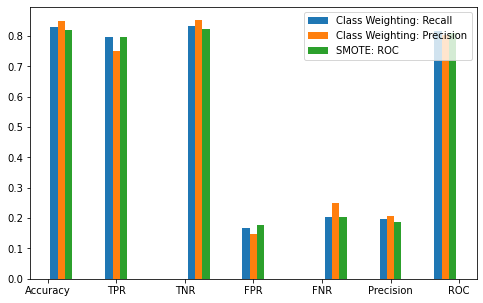

In [138]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins], 15, weights=[stats[3][:-1], stats[2][:-1], stats_smote[1][:-1]], 
            histtype='bar', label=['Class Weighting: Recall', 'Class Weighting: Precision', 'SMOTE: ROC'])
plt.legend()

__Select Best Model: SMOTE ROC__     

In [207]:
best_model_log = model_list_smote[0]
predict, prob, predict_df, true_df, prob_df, coef_dict = model_predict(best_model_log)

In [117]:
metrics_print(predict_df, predict)

Accuracy: 0.82128740824393
TPR/recall: 0.7976878612716763
TNR: 0.8224992579400415
FPR: 0.17750074205995844
FNR: 0.2023121387283237
Precision: 0.1875
Area under ROC: 0.8100935596058589
Area Under PR: 0.1594478969133405


[0.82128740824393,
 0.7976878612716763,
 0.8224992579400415,
 0.17750074205995844,
 0.2023121387283237,
 0.1875,
 0.8100935596058589,
 0.1594478969133405]

In [118]:
coef_dict 

{'telecommuting': -0.15589028218377787,
 'has_company_logo': -2.2577460774232128,
 'has_questions': -0.2490961604294492,
 'topic0': 1.7922765821204676,
 'topic1': -3.4163983631897406,
 'topic2': -7.1688943015802575,
 'topic3': 2.4452079517332135,
 'topic4': 1.3715976993630596,
 'topic5': 0.0,
 'topic6': 1.6253059718627327,
 'topic7': -4.4456438674991805,
 'topic8': -5.713372527598716,
 'topic9': 7.075523552930916,
 'topic10': -4.161553759534891,
 'topic11': 4.664729567206485,
 'topic12': -7.100562583754289,
 'topic13': -5.656627263082867,
 'topic14': 4.933339446152266,
 'topic15': 2.062640338180358,
 'topic16': 1.79393104804954,
 'topic17': 2.0848669036272893,
 'topic18': -0.09879294249319286,
 'topic19': 7.994221418289615,
 'topic20': -0.8046801647731574,
 'topic21': 7.62646418709529,
 'employment_type_contract': -0.6355225965538801,
 'employment_type_fulltime': 0.09416154691242333,
 'employment_type_other': -0.24248135637266904,
 'employment_type_parttime': -0.9977078330645186,
 'emp

__Examine Different Thresholds from best model__          
Not large shifts. Given ROC curve below, sticking with 0.5

In [119]:
threshold_list = [0.4, 0.45, 0.5, 0.55, 0.6]
for i in threshold_list: 
    pred_thresh = prob_df.applymap(lambda x: 1 if x>i else 0)
    pred_thresh = pd.merge(pred_thresh, true_df, left_index = True, right_index = True)
    pred_thresh.columns = ['', 'predict', 'truth']
    
    print(i)
    metrics_print(pred_thresh, predict)

0.4
Accuracy: 0.7865612648221344
TPR/recall: 0.861271676300578
TNR: 0.7827248441674087
FPR: 0.21727515583259127
FNR: 0.13872832369942195
Precision: 0.16912599318955732
Area under ROC: 0.8100935596058589
Area Under PR: 0.1594478969133405
0.45
Accuracy: 0.8026538678712591
TPR/recall: 0.8323699421965318
TNR: 0.8011279311368359
FPR: 0.19887206886316414
FNR: 0.1676300578034682
Precision: 0.1769041769041769
Area under ROC: 0.8100935596058589
Area Under PR: 0.1594478969133405
0.5
Accuracy: 0.82128740824393
TPR/recall: 0.7976878612716763
TNR: 0.8224992579400415
FPR: 0.17750074205995844
FNR: 0.2023121387283237
Precision: 0.1875
Area under ROC: 0.8100935596058589
Area Under PR: 0.1594478969133405
0.55
Accuracy: 0.8390739695087521
TPR/recall: 0.7745664739884393
TNR: 0.8423864648263579
FPR: 0.15761353517364202
FNR: 0.2254335260115607
Precision: 0.20150375939849624
Area under ROC: 0.8100935596058589
Area Under PR: 0.1594478969133405
0.6
Accuracy: 0.8529079616036138
TPR/recall: 0.7341040462427746
TN

__Graph ROC Curve of best model__        
0.5 threshold does a good job of getting to the closest to the upper left corner

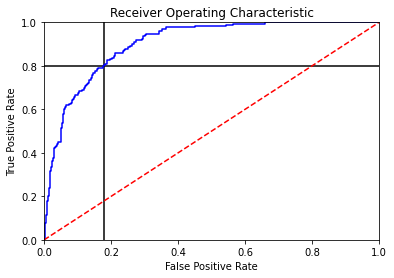

In [209]:
fpr, tpr, threshold = metrics.roc_curve(y_test.fraudulent.to_list(), prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b') 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# find 0.5 threshold 
threshold5 = np.argmin([abs(i-0.5) for i in threshold]) # value closet to 0.5 in threshold list
plt.vlines(x = fpr[threshold5], ymin = 0, ymax = 1)
plt.hlines(y = tpr[threshold5], xmin = 0, xmax = 1)

plt.show()

# Ensemble Tree Models
Code modified from 
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ and https://machinelearningmastery.com/xgboost-for-imbalanced-classification/   
Specifically, guidance in how to and in what order to tune parameters from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ 

In [211]:
# train/test split + SMOTE sampling
X_train, X_test, y_train, y_test, os_data_X, os_data_y = smote(df_mod) 
# don't need to drop one level of dummies in this case so use df_mod, not df_reg

Original number of fraudulent in data is 687
length of oversampled data is  26956
Number of real in oversampled data 13478
Number of fraudulent 13478
Proportion of real data in oversampled data is  0.5
Proportion of fraudulent data in oversampled data is  0.5


### Baseline Model
Results with all default values. 3 iterations: unbalanced origianl data, SMOTE, balanced class weighting
Error due to printing, model still trains correclty

In [27]:
# unbalanced
xgb = XGBClassifier(objective = 'binary:logistic')
xgb.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb, logistic = False)
xgb_baseline = metrics_print(predict_df, predict)
# precision, TPR very good but recall poor

Accuracy: 0.9762845849802372
TPR/recall: 0.6011560693641619
TNR: 0.9955476402493322
FPR: 0.004452359750667854
FNR: 0.3988439306358382
Precision: 0.8739495798319328
Area under ROC: 0.7983518548067471
Area Under PR: 0.5448606137147449


In [28]:
# SMOTE
xgb = XGBClassifier(objective = 'binary:logistic')
xgb.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb, logistic = False)
xgb_baseline_smote = metrics_print(predict_df, predict)
# recall better but still not great

Accuracy: 0.9720496894409938
TPR/recall: 0.6936416184971098
TNR: 0.9863460967646186
FPR: 0.01365390323538142
FNR: 0.3063583815028902
Precision: 0.7228915662650602
Area under ROC: 0.8399938576308643
Area Under PR: 0.5163909735940003


In [29]:
# class balanced weighting
# calculate balance weight ratio 
scale_weight = len(y_train[y_train.fraudulent == 0]) / len(y_train[y_train.fraudulent == 1])

xgb = XGBClassifier(objective = 'binary:logistic', scale_pos_weight = scale_weight)
xgb.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb, logistic = False)
xgb_baseline_bal = metrics_print(predict_df, predict)
# poor precision, best recall and ROC out of the 3. Overall pretty good

Accuracy: 0.961038961038961
TPR/recall: 0.7976878612716763
TNR: 0.9694271297120808
FPR: 0.030572870287919263
FNR: 0.2023121387283237
Precision: 0.5726141078838174
Area under ROC: 0.8835574954918787
Area Under PR: 0.46664874597673245


# UPDATED
Compare Baselines     
- Imbalanced does better than in logistic - more fake predictions
- Class weighting relatively poor precision but good recall/TPR
- SMOTE fairly balanced 

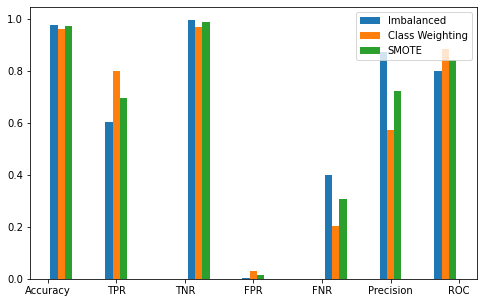

In [32]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins], 15,
         weights=[xgb_baseline[:-1], xgb_baseline_bal[:-1], xgb_baseline_smote[:-1]], 
         histtype='bar', label=['Imbalanced', 'Class Weighting', 'SMOTE'])
plt.legend()

### Parameter Tuning    
Ideally would do full grid search with all parameters, but resource needs too much so doing sequential tuning instead   
Tune most parameters with high learning rate (0.3) and low number of estimators (100) so that reasonable amount of time. Last step is to select correect learning rate and estimator number.         

Parameters: 
- Max depth: maximum tree depth. Larger makes trees more complex, more likely to overfit
- Min child weight: minimum sum of weight eeded in a child. Will stop splitting nodes if result is below this minimum
- Gamma: minimum loss reduction required for a tree split
- Subsample: percent of data sampled to grow trees at each iteration. Smaller subsamples prevents overfitting
- Colsample_bytree: percent of features used when constructing tree for each tree created
- Alpha: L1 regularizastion
- Lambda: L2 regularization
- Learning rate: how quickly trees learn/update in iterations. 
- Number of estimators: number of trees/iterations    
         
Fit models with each of the 4 scoring metrics for both SMOTE and class weighted data

In [128]:
# function to iterate through various parameter tunings, select the best value, apply it, and then tune next param
# inputs:
    # score: desired scoring metric used in CV
    # x,y: x and y training data
    # scale_pos_weight: when doing class weighting, give positive class weight 
def xgb_tune(score, x, y, scale_pos_weight = 1):
    
    print('start')

    # max depth and min child weight
    xgb1 = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.3, n_estimators = 100, 
                         scale_pos_weight = scale_pos_weight)
    param_grid = dict(max_depth = range(3, 12, 1), min_child_weight = range(1, 6, 1))
    grid = GridSearchCV(estimator =xgb1, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    max_depth = grid_result.best_params_['max_depth']
    min_child_weight = grid_result.best_params_['min_child_weight']
    
    # gamma - minimum loss reduction required for a tree split
    xgb2 = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.3, n_estimators=100, max_depth = max_depth, 
                         min_child_weight = min_child_weight, scale_pos_weight = scale_pos_weight)
    param_grid = dict(gamma = [i/10 for i in range(0, 5)])
    grid = GridSearchCV(estimator = xgb2, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
    
    gamma = grid_result.best_params_['gamma']
    
    # subsample and colsample_bytree
    xgb3 = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.3, n_estimators=100, max_depth = max_depth,
                         min_child_weight = min_child_weight, gamma = gamma, scale_pos_weight = scale_pos_weight)
    param_grid = dict(subsample = [i/10 for i in range(6,11)], colsample_bytree = [i/10 for i in range(6,11)])
    grid = GridSearchCV(estimator = xgb3, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
    
    subsample = grid_result.best_params_['subsample']
    colsample_bytree= grid_result.best_params_['colsample_bytree']
    
    # regularization alpha and lambda
    xgb4 = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.3, n_estimators=100, max_depth = max_depth, 
                         min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                         colsample_bytree = colsample_bytree, scale_pos_weight = scale_pos_weight)
    param_grid = dict(reg_alpha = [0, 0.001, 0.005, 0.01, 0.05], reg_lambda = [1, 0.95, 0.9, 0.85, 0.8])
    grid = GridSearchCV(estimator = xgb4, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 
    
    reg_alpha = grid_result.best_params_['reg_alpha']
    reg_lambda = grid_result.best_params_['reg_lambda']
    
    # learning rate and n estimators. Add early stopping rounds to help with train speed
    xgb5 = XGBClassifier(objective = 'binary:logistic',  max_depth = max_depth, 
                         min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                         colsample_bytree = colsample_bytree, reg_alpha = reg_alpha, reg_lambda = reg_lambda,
                        early_stopping_rounds = 30, scale_pos_weight = scale_pos_weight)
    param_grid = dict(learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3], n_estimators = [100, 500, 1000])
    grid = GridSearchCV(estimator = xgb5, param_grid=param_grid, n_jobs=-1, cv=5, scoring=score)
    grid_result = grid.fit(x.values, y.fraudulent.values)
    print(str(score), "Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 

__SMOTE: tune for each scoring metric and graph results__      
For each scoring metric, find and print best parameters. Then fit model with selected params and pring resulting metrics.    
      
In general, very overfit. Ex: ROC on training CV 0.999, on testing 0.83     
          
Best model: ROC (all very similar)

In [129]:
xgb_tune('roc_auc', x = os_data_X, y = os_data_y) 

start
roc_auc Best: 0.999318 using {'max_depth': 10, 'min_child_weight': 1}
roc_auc Best: 0.999318 using {'gamma': 0.0}
roc_auc Best: 0.999362 using {'colsample_bytree': 0.7, 'subsample': 0.7}
roc_auc Best: 0.999362 using {'reg_alpha': 0, 'reg_lambda': 1}
[21:07:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


roc_auc Best: 0.999415 using {'learning_rate': 0.05, 'n_estimators': 500}


In [33]:
xgb_roc = XGBClassifier(objective = 'binary:logistic', max_depth = 10, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 0.7, subsample = 0.7, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.05, n_estimators = 500)
xgb_roc.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_roc, logistic = False)
stats_roc = metrics_print(predict_df, predict)

Accuracy: 0.9754376058723885
TPR/recall: 0.7109826589595376
TNR: 0.9890175126150192
FPR: 0.010982487384980706
FNR: 0.28901734104046245
Precision: 0.76875
Area under ROC: 0.8500000857872784
Area Under PR: 0.5606842375392891


In [131]:
xgb_tune('precision', x = os_data_X, y = os_data_y)  

start
precision Best: 0.988833 using {'max_depth': 8, 'min_child_weight': 1}
precision Best: 0.988833 using {'gamma': 0.0}
precision Best: 0.988833 using {'colsample_bytree': 1.0, 'subsample': 1.0}
precision Best: 0.988833 using {'reg_alpha': 0, 'reg_lambda': 1}
[21:56:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


precision Best: 0.989345 using {'learning_rate': 0.3, 'n_estimators': 1000}


In [34]:
xgb_prec = XGBClassifier(objective = 'binary:logistic', max_depth = 8, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 1, subsample = 1, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.3, n_estimators = 1000)
xgb_prec.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_prec, logistic = False)
stats_prec = metrics_print(predict_df, predict)

Accuracy: 0.9745906267645398
TPR/recall: 0.7109826589595376
TNR: 0.9881270406648858
FPR: 0.011872959335114277
FNR: 0.28901734104046245
Precision: 0.754601226993865
Area under ROC: 0.8495548498122117
Area Under PR: 0.5506247052863723


In [132]:
xgb_tune('recall', x = os_data_X, y = os_data_y)  

start
recall Best: 0.989614 using {'max_depth': 11, 'min_child_weight': 1}
recall Best: 0.989614 using {'gamma': 0.0}
recall Best: 0.990133 using {'colsample_bytree': 0.7, 'subsample': 0.7}
recall Best: 0.990133 using {'reg_alpha': 0, 'reg_lambda': 1}
[22:39:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


recall Best: 0.990430 using {'learning_rate': 0.01, 'n_estimators': 500}


In [35]:
xgb_rec = XGBClassifier(objective = 'binary:logistic', max_depth = 11, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 0.7, subsample = 0.7, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.01, n_estimators = 500)
xgb_rec.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_rec, logistic = False)
stats_rec = metrics_print(predict_df, predict)

Accuracy: 0.9647092038396387
TPR/recall: 0.7109826589595376
TNR: 0.9777382012466608
FPR: 0.02226179875333927
FNR: 0.28901734104046245
Precision: 0.6212121212121212
Area under ROC: 0.8443604301030991
Area Under PR: 0.45578736418143306


In [133]:
xgb_tune('accuracy',  x = os_data_X, y = os_data_y)  

start
accuracy Best: 0.988909 using {'max_depth': 8, 'min_child_weight': 1}
accuracy Best: 0.988909 using {'gamma': 0.0}
accuracy Best: 0.988909 using {'colsample_bytree': 1.0, 'subsample': 1.0}
accuracy Best: 0.988909 using {'reg_alpha': 0, 'reg_lambda': 1}
[23:22:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


accuracy Best: 0.989094 using {'learning_rate': 0.3, 'n_estimators': 1000}


In [36]:
xgb_acc = XGBClassifier(objective = 'binary:logistic', max_depth = 8, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 1.0, subsample = 1.0, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.3, n_estimators = 1000)
xgb_acc.fit(os_data_X.values, os_data_y.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_acc, logistic = False)
stats_acc = metrics_print(predict_df, predict)

Accuracy: 0.9745906267645398
TPR/recall: 0.7109826589595376
TNR: 0.9881270406648858
FPR: 0.011872959335114277
FNR: 0.28901734104046245
Precision: 0.754601226993865
Area under ROC: 0.8495548498122117
Area Under PR: 0.5506247052863723


# UPDATED
Insights:
- All very similar, ROC slightly better across most metrics
- Recall worse precision
- Concerns about overfitting: when training, ROC was 0.999 but 0.83 on testing data. Worried that if get new test data, won't perform well because too variable.     
          
Best model: ROC

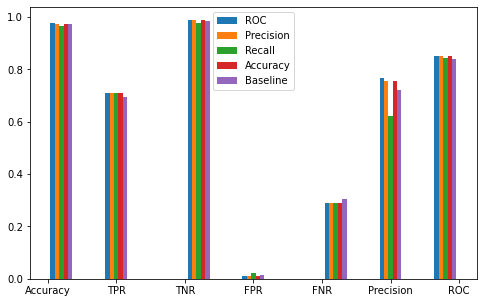

In [41]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins, bins], 15,
         weights=[stats_roc[:-1], stats_prec[:-1], stats_rec[:-1], stats_acc[:-1], xgb_baseline_smote[:-1]], 
         histtype='bar', label=['ROC', 'Precision', 'Recall', 'Accuracy', 'Baseline'])
plt.legend()

__Balanced Weighting: tune for each scoring metric and graph results__     
For each scoring metric, find and print best parameters. Then fit model with selected params and pring resulting metrics.    
           
Overfitting is better. Ex 0.97 on train CV, 0.85 on test for ROC.        
           
Best model: ROC

In [134]:
xgb_tune('roc_auc', x = X_train, y = y_train, scale_pos_weight = scale_weight) 

start
roc_auc Best: 0.971799 using {'max_depth': 9, 'min_child_weight': 4}
roc_auc Best: 0.971799 using {'gamma': 0.0}
roc_auc Best: 0.972532 using {'colsample_bytree': 0.6, 'subsample': 1.0}
roc_auc Best: 0.973243 using {'reg_alpha': 0.005, 'reg_lambda': 0.95}
[23:39:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


roc_auc Best: 0.974514 using {'learning_rate': 0.05, 'n_estimators': 500}


In [43]:
xgb_roc_bal = XGBClassifier(objective = 'binary:logistic', max_depth = 9, min_child_weight = 4, gamma = 0.0, 
                          colsample_bytree = 0.6, subsample = 1, reg_alpha = 0.005, reg_lambda = 0.95, 
                          learning_rate = 0.05, n_estimators = 500, scale_pos_weight = scale_weight)
xgb_roc_bal.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_roc_bal, logistic = False)
stats_roc_bal = metrics_print(predict_df, predict)

Accuracy: 0.9751552795031055
TPR/recall: 0.6878612716763006
TNR: 0.9899079845651528
FPR: 0.010092015434847135
FNR: 0.31213872832369943
Precision: 0.7777777777777778
Area under ROC: 0.8388846281207267
Area Under PR: 0.5502488352450655


In [135]:
xgb_tune('precision', x = X_train, y = y_train, scale_pos_weight = scale_weight) 

start
precision Best: 0.812730 using {'max_depth': 11, 'min_child_weight': 1}
precision Best: 0.812730 using {'gamma': 0.0}
precision Best: 0.842431 using {'colsample_bytree': 0.8, 'subsample': 1.0}
precision Best: 0.842431 using {'reg_alpha': 0, 'reg_lambda': 1}
[23:59:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


precision Best: 0.862033 using {'learning_rate': 0.2, 'n_estimators': 1000}


In [44]:
xgb_prec_bal = XGBClassifier(objective = 'binary:logistic', max_depth = 11, min_child_weight = 1, gamma = 0, 
                          colsample_bytree = 0.8, subsample = 1.0, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.2, n_estimators = 1000, scale_pos_weight = scale_weight)
xgb_prec_bal.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_prec_bal, logistic = False)
stats_prec_bal = metrics_print(predict_df, predict)

Accuracy: 0.9757199322416714
TPR/recall: 0.6647398843930635
TNR: 0.99168892846542
FPR: 0.008311071534579995
FNR: 0.3352601156069364
Precision: 0.8041958041958042
Area under ROC: 0.8282144064292418
Area Under PR: 0.5509559553289133


In [136]:
xgb_tune('recall', x = X_train, y = y_train, scale_pos_weight = scale_weight) 

start
recall Best: 0.813615 using {'max_depth': 3, 'min_child_weight': 2}
recall Best: 0.813615 using {'gamma': 0.0}
recall Best: 0.818037 using {'colsample_bytree': 0.6, 'subsample': 1.0}
recall Best: 0.818037 using {'reg_alpha': 0, 'reg_lambda': 1}
[00:09:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


recall Best: 0.855834 using {'learning_rate': 0.1, 'n_estimators': 100}


In [45]:
xgb_rec_bal = XGBClassifier(objective = 'binary:logistic', max_depth = 3, min_child_weight = 2, gamma = 0.4, 
                          colsample_bytree = 0.6, subsample = 1.0, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.1, n_estimators = 100, scale_pos_weight = scale_weight)
xgb_rec_bal.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_rec_bal, logistic = False)
stats_rec_bal = metrics_print(predict_df, predict)

Accuracy: 0.8867871259175607
TPR/recall: 0.8554913294797688
TNR: 0.8883941822499258
FPR: 0.11160581775007421
FNR: 0.14450867052023122
Precision: 0.2824427480916031
Area under ROC: 0.8719427558648474
Area Under PR: 0.24868548129887724


In [137]:
xgb_tune('accuracy',  x = X_train, y = y_train, scale_pos_weight = scale_weight) 

start
accuracy Best: 0.976491 using {'max_depth': 7, 'min_child_weight': 4}
accuracy Best: 0.976491 using {'gamma': 0.0}
accuracy Best: 0.976491 using {'colsample_bytree': 1.0, 'subsample': 1.0}
accuracy Best: 0.976491 using {'reg_alpha': 0, 'reg_lambda': 1}
[00:27:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


accuracy Best: 0.977480 using {'learning_rate': 0.3, 'n_estimators': 1000}


In [46]:
xgb_acc_bal = XGBClassifier(objective = 'binary:logistic', max_depth = 7, min_child_weight = 4, gamma = 0, 
                          colsample_bytree = .10, subsample = 1.0, reg_alpha = 0, reg_lambda = 1, 
                          learning_rate = 0.3, n_estimators = 1000, scale_pos_weight = scale_weight)
xgb_acc_bal.fit(X_train.values, y_train.fraudulent.values)
predict, prob, predict_df, true_df, prob_df = model_predict(xgb_acc_bal, logistic = False)
stats_acc_bal = metrics_print(predict_df, predict)

Accuracy: 0.9697910784867306
TPR/recall: 0.5895953757225434
TNR: 0.9893143365983972
FPR: 0.01068566340160285
FNR: 0.41040462427745666
Precision: 0.7391304347826086
Area under ROC: 0.7894548561604703
Area Under PR: 0.45583305862270423


# UPDATED
Insights:
- ROC overall most balanced. Very similar to precision
- Recall much higher TPR, FPR. Low precision    
- Baseline better ROC and FNR than tuned models. But worse precision. 
     
Best: ROC 

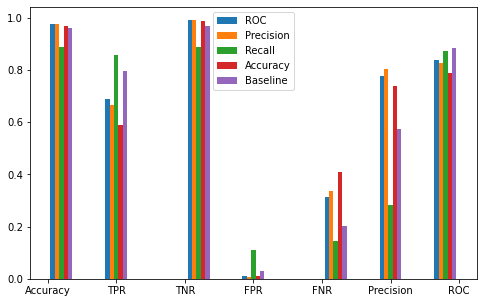

In [48]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins, bins, bins, bins], 15, weights=[stats_roc_bal[:-1], stats_prec_bal[:-1], 
                                                stats_rec_bal[:-1], stats_acc_bal[:-1], xgb_baseline_bal[:-1]], 
            histtype='bar', label=['ROC', 'Precision', 'Recall', 'Accuracy', 'Baseline'])
plt.legend()

__Compare class imbalance vs SMOTE__    
Best models from each    
Very similar, class weighting slightly better in all categories and less overfit, so choosing this as best model

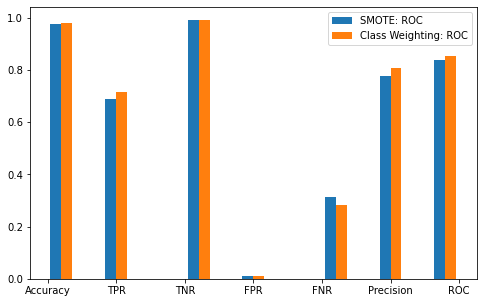

In [150]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins], 15, weights=[stats_roc[:-1], stats_roc_bal[:-1]], 
            histtype='bar', label=['SMOTE: ROC', 'Class Weighting: ROC'])
plt.legend()

## Compare xgboost and logistic   
Best model: XGBoost, class weighting, ROC scoring     
XGBoost overall better for accuracy, TNR, precision, FPR, ROC. Worse for TPR and FNR, but by small amounts
       
Thoughts on tradeoffs:    
Originally thought we wanted to minimize FNR/maximize recall so that job seekers don't think a fake job is real. However, never do a good job in any model of really minimizing FNR.       
However, can do a very good job of maximizing precision and minimizing FPR. Thus very rarely predict a real job is fake. This actually has benefits to the job seekers (don't miss out on opportunities) and the companies (don't have their posts labeled as fake).     
Would need disclaimers that this does not guarentee the post is not fake, just provides a first pass to filter some out. Please still be vigilant. 

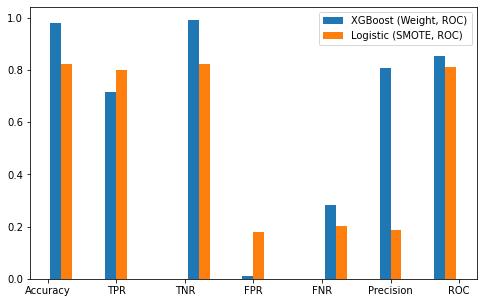

In [153]:
fig, ax = plt.subplots(figsize=(8,5))

bins = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision', 'ROC']
plt.hist([bins, bins], 15, weights=[stats_roc_bal[:-1],  stats_smote[1][:-1]], 
            histtype='bar', label=['XGBoost (Weight, ROC)', 'Logistic (SMOTE, ROC)'])
plt.legend()

## Overall Best Model: XGBoost Class Weighting, ROC Scoring

__Print Metrics__

In [212]:
best_mod = xgb_roc_bal
predict, prob, predict_df, true_df, prob_df = model_predict(best_mod, logistic = False)
stats_roc_bal = metrics_print(predict_df, predict)

Accuracy: 0.9776962168266516
TPR/recall: 0.7167630057803468
TNR: 0.9910952804986642
FPR: 0.008904719501335707
FNR: 0.2832369942196532
Precision: 0.8051948051948052
Area under ROC: 0.8539291431395054
Area Under PR: 0.5909678409050111


__ROC Curve__

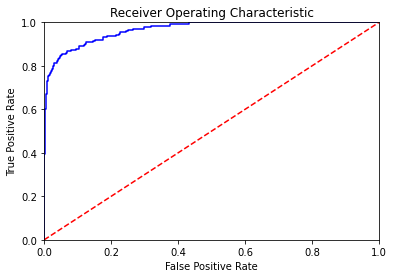

In [162]:
fpr, tpr, threshold = metrics.roc_curve(y_test.fraudulent.to_list(), prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

In [216]:
# save fpr, tpr data for plotting in dashboard

with open('tpr.pkl', 'wb') as f:
    pickle.dump(tpr, f)
with open('fpr.pkl', 'wb') as f:
    pickle.dump(fpr, f)

### Feature Importance

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

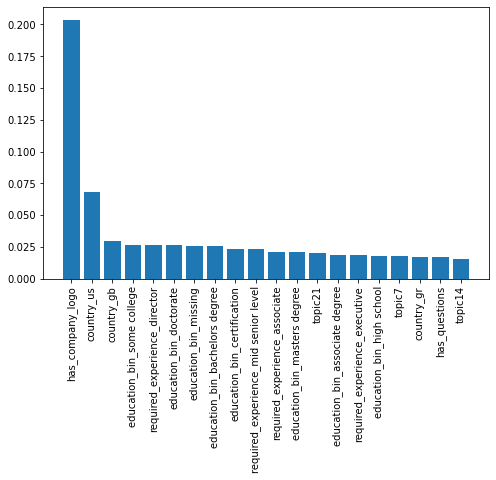

In [214]:
# get feature importance
cols = pd.Series(X_train.columns).to_frame()
fimport = pd.Series(xgb_roc_bal.feature_importances_).to_frame()

# merge with column names
fimport = pd.merge(cols, fimport, left_index = True, right_index = True)
fimport.columns = ['col', 'import']
fimport = fimport.sort_values('import', ascending = False)
fimport = fimport[fimport['import'] > 0] # remove if importance = 0
fimport = fimport.head(20) # top 20 only so chart readable

# plot 
fig, ax = plt.subplots(figsize=(8,5))
plt.bar(fimport.col, height = fimport['import'])
plt.xticks(rotation=90)

__Merge Predictions with Full Test Data for Display in Dashboard__

In [182]:
# original data before column dropping: limit to test indicies
df_test = df[df.index.isin(y_test.index.to_list())]
# need to sort in same order as test data so can merge with predictions
y_test['order'] = 1 # record order (cumulative sum)
y_test.order = y_test.order.cumsum()
del y_test['fraudulent']
df_test = pd.merge(df_test, y_test, left_index = True, right_index = True) # merge on index
df_test = df_test.sort_values('order') # resort by original test order

In [185]:
# merge with predictions
df_test = df_test.reset_index(drop = True)
pred_full = pd.merge(df_test, predict_df, left_index = True, right_index = True)

# merge with probabilities
prob_df.columns = ['prob_real', 'prob_fake']
pred_full = pd.merge(pred_full, prob_df[['prob_fake']], left_index = True, right_index = True)

In [188]:
# save dataset with predictions for dashboard presentation
pred_full.to_csv('data_with_predictions.csv')

In [190]:
pred_full.columns

Index(['job_id', 'title', 'location', 'department', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'country', 'state', 'city', 'language', 'education_bin',
       'fraudulent_words', 'text', 'parse', 'topic0', 'topic1', 'topic2',
       'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9',
       'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15',
       'topic16', 'topic17', 'topic18', 'topic19', 'topic20', 'topic21',
       'employment_type_contract', 'employment_type_fulltime',
       'employment_type_missing', 'employment_type_other',
       'employment_type_parttime', 'employment_type_temporary',
       'required_experience_associate', 'required_experience_director',
       'required_experience_entry level', 'required_experience_executive',
       'require